<a href="https://colab.research.google.com/github/anderhos/Applied-Machine-Learning/blob/master/cnn_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CA2 - DAT300 - Compulsory Assignment 2
 - Kaggle name : Group_2
 - Group number : Group 2 
 - Members : Anders Mølmen Høst , Ghazal Azadi ,Meera Joseph

## Cloud segmentation on satellite images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
 # Check existence of file
!ls /.kaggle
!cat /.kaggle/kaggle.json

kaggle.json
{"username":"ghazalazadi","key":"0db2f005a4621c275acdc5c675021e52"}

In [ ]:
 # Notice the difference in path names with/without ~
!mkdir -p ~/.kaggle
!cp /.kaggle/kaggle.json ~/.kaggle/

In [ ]:
 # Install Python part of kaggle
!pip install kaggle

In [ ]:
!kaggle competitions download -c dat300-h2020-ca2

train.h5.zip: Skipping, found more recently modified local copy (use --force to force download)
test.h5.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/test.h5.zip -d /content/

Archive:  /content/test.h5.zip
replace /content/test.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/train.h5.zip -d /content/

### Load modules

In [ ]:
import tensorflow as tf
from PIL.Image import fromarray
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras import activations
import h5py
import numpy as np

from keras import backend as K
from numpy import concatenate

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model


###1. Get data from the HDF5 file:

In [ ]:
with h5py.File('/content/train.h5', 'r') as hf:
    print(hf.keys())

<KeysViewHDF5 ['X', 'y']>


In [ ]:
with h5py.File('train.h5', 'r') as hf:
    X_data = hf['X'][:]
    y_data = hf['y'][:]

In [ ]:
with h5py.File('test.h5', 'r') as hf:
    X_test = hf['X'][:]

In [ ]:
X_data.shape

(3000, 128, 128, 4)

### 2. Preprocessing

Plotting the first 9 images and 
corresponding masks

In [ ]:
def plot_img(X):
  # We need our date normalized and in floating point representation
  # to be able to plot our data using imshow
  X = X.astype('float32')
  X = X/np.max(X)
  for i in range(0, 9):
      plt.subplot(330 + 1 + i)
      plt.imshow(X[i,:,:,:-1])
  return plt.show()









  

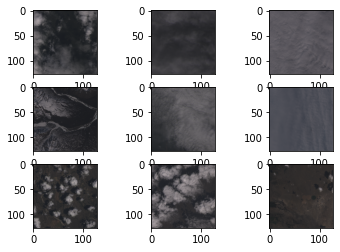

In [ ]:
plot_img(X_data)

In [ ]:
y_data

array([[[[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],

        ...,

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]],

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00392157]]],


       [[[0.00392157],
         [0.00392157],
         [0.00

In [ ]:
y_data = y_data/255

In [ ]:
def plot_mask(y):
  for i in range(0, 9):
      plt.subplot(330 + 1 + i)
      plt.imshow(y_data[i,:,:,0])
  return plt.show

<function matplotlib.pyplot.show>

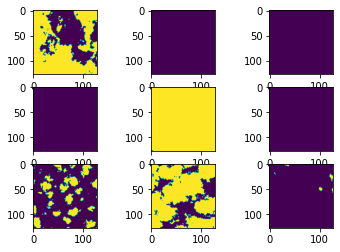

In [ ]:
plot_mask(y_data)

In [ ]:
# Partition and split into training and validation data
X_train, y_train = X_data[:2400, :], y_data[:2400]
X_valid, y_valid = X_data[2400:3000, :], y_data[2400:3000]

In [ ]:
# Standardize data pixel wise

mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train, axis=0)

X_train_centered = (X_train - mean_vals) / std_val
X_valid_centered = (X_valid - mean_vals) / std_val
X_test_centered = (X_test  - mean_vals) / std_val

In [ ]:
X_train_centered.shape

(2400, 128, 128, 4)

In [ ]:
X_valid_centered.shape

(600, 128, 128, 4)

In [ ]:
X_test_centered.shape

(500, 128, 128, 4)

In [ ]:
y_valid.shape

(600, 128, 128, 1)

###TASK :
##### Create a basic U-Net with optional dropout. Use a proportion of the images for validation when training. The minimum requirement is to tune the following parameters: number of convolutional filters, dropout and learning rate.  Report strategies and scores leading up to the final choice. If time permits, we recommend adding augmentation (both images and masks) and changing the loss function, e.g. implementing F1. More exotic networks and tuning is also allowed as long as you show that you know how to use U-Nets too.

### 3. Unet model for image segmentation 
using sigmoid as the activation function 

In [ ]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#### 3.1 Code for F1, precision and recall for keras model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
from keras import backend as K

smooth = 0.0000001


def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

### 3.2 build the unet model with input image

In [ ]:
input_img = Input(shape=(128,128,4))
model = get_unet(input_img, n_filters = 64, dropout = 0, batchnorm = True, n_classes = 1)
#model.summary()

### 3.2.1 Inspect the model

Use summary method to print a simple description of the model

In [ ]:
model.summary()

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f4a4017e080>>

### 3.3 Compile the model and train the model on the training data , evaluate the model performance on the validation data set
To save time in training, we start by training our model using 500 examples. We tune our parameters and get an idea of how our model performs. Then we continue with a split of 2400 training examples and 600 validation examples.

What we observed here was that the learning rate can change the performance of the model significantly. And by test and error, seems like for this specific problem, learning rate of 0.0001 works well.

- The model parameter learning rate was found and fixed through trial and error for the best performance
- The batch size and number of epochs where also adjusted to optimise the results

In [ ]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adamax'), loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m,dice_coef])

After training our model, we observe that the validation data generalises the training data well at 20 epochs with batch size 50. We continue using the same settings in our model on the whole training data.

### 4. Train the final model on whole training data and then make the predictions on the test data

- Standardised the whole X_data befor fitting the model

In [ ]:
mean_vals = np.mean(X_data, axis=0)
std_val = np.std(X_data)

X_data_centered = (X_data - mean_vals)/std_val

print(X_data_centered.shape)

(3000, 128, 128, 4)


In [ ]:
model.fit(X_data_centered, y_data, epochs=20, verbose=0, batch_size=50)

In [ ]:
model.evaluate(X_data_centered, y_data, verbose=0)

[0.09390587359666824,
 0.9629580974578857,
 0.9611641764640808,
 0.9696094989776611,
 0.9530960917472839,
 0.7130821943283081]

In [ ]:
y_pred = model.predict(X_test_centered)

In [ ]:
y_pred.shape

(500, 128, 128, 1)

### 4.1 Flatten the predected y data and map it to True and false , where True stands for cloud and False for not a cloud , covert it to csv and upload to kaggle 

In [ ]:
y_pred2=np.where(y_pred[:,:,:,] >= 0.5, 'True', 'False')
y_pred2=y_pred2.flatten()

In [ ]:
solution = pd.DataFrame(columns = ['Predicted'], data = y_pred2)
solution.to_csv('predict23.csv', index_label="ID")
!kaggle competitions submit -c dat300-h2020-ca2 -f predict23.csv.csv -m "Message"

In [ ]:
import pandas as pd
import numpy as np

ID = np.arange(0,8192000)
h = np.column_stack((ID,y_pred2))
df2 = pd.DataFrame(data=h)

df2.columns=['ID','Predicted']
df2["ID"]=df2["ID"].astype(int)

In [ ]:

df2.to_csv(r'\predict23.csv', index = False)

### CONCLUSION: The implementation of model using basic unet with sigmoid activation fuction and small adjustments in learning rates gave a goood f1 score .

- Running the model in the orion cluster reduced the time taken to run 20 epochs from  771.1 seconds in google collab using GPU to Done in 295.1 seconds seconds which was obtained from the log for the job

Submitting predictions from orion to kaggle

In [ ]:
!kaggle competitions submit -c dat300-h2020-ca2 -f  predict2.csv -m "result generated on orion cluster"

#### 1. Why did we use Dice Coefficient and Jaccard Index ?

    ans: In order to find if segmentation task is performing well

- Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

- Jaccard Index : We use IoU (Intersection-Over-Union also known as Jaccard Index)is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.
 reffered from :https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

